# Laboratory 4

### Configuration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
import pandas as pd
from random import uniform
import sortedcontainers as sc
from queue import PriorityQueue
%matplotlib notebook

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))


class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfaces

[Available colors](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Available points markers](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines
    
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Next')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Previous')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Add point')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Add line')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Add figure')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None

    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

## Solution

### Function for getting added interactively line segments

In [3]:
def get_added_lines(plot):
    lines = plot.get_added_lines()[0].lines
    i = 0
    while i < len(lines):
        (x1, y1), (x2, y2) = lines[i]
        if x1 == x2:
            lines[len(lines) - 1], lines[i] = lines[i], lines[len(lines) - 1]
            lines.pop()
        else:
            i += 1
    
    for i in range(len(lines)):
        lines[i] = tuple(lines[i])
    
    return lines

### Function for drawing line segments from some given range

In [4]:
def draw_line_segments(x_range, y_range, n):
    lines = []
    while len(lines) != n:
        a_x, b_x = x_range
        a_y, b_y = y_range
        x1, x2 = uniform(a_x, b_x), uniform(a_x, b_x)
        if x1 != x2:
            if x1 < x2:
                lines.append(((x1, uniform(a_y, b_y)), (x2, uniform(a_y, b_y))))
            else:
                lines.append(((x2, uniform(a_y, b_y)), (x1, uniform(a_y, b_y))))
    return lines

### Function for computing 2x2 determinant

In [5]:
def det2x2(a, b, c):
    return (a[0] - c[0]) * (b[1] - c[1]) - (a[1] - c[1]) * (b[0] - c[0])

In [6]:
class Point:
    def __init__(self, x, y, s, t):
        self.x = x
        self.y = y
        self.s = s
        self.t = t
        
    def __gt__(self, other):
        return self.x < other.x
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def __hash__(self):
        return hash((self.x, self.y))

In [7]:
class Line:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.m = (self.start.y - self.end.y) / (self.start.x - self.end.x)
        self.b = (self.start.y - self.m * self.start.x)
    
    def set_ordering(x):
        Line.ordering_x = x
    
    def __eq__(self, other):
        return self.start == other.start and self.end == other.end
    
    def __gt__(self, other):
        return self.m * Line.ordering_x + self.b > other.m * Line.ordering_x + other.b
    
    def __hash__(self):
        return hash((self.start, self.end))

### Function for preparing the data - removing duplicates and vertical lines

In [8]:
def prepare_data(lines):
    res_lines = []
    points = []
    limit_max = -float("inf")
    limit_min = float("inf")
    x_cords = set()
    for line in lines:
        n = len(res_lines)
        if line[0][0] == line[1][0]:
            continue
            
        if line[0][0] not in x_cords and line[1][0] not in x_cords:
            x_cords.add(line[0][0])
            x_cords.add(line[1][0])
        else:
            continue
        
        start = Point(line[0][0], line[0][1], n, n)
        end = Point(line[1][0], line[1][1], n, n)
        if end.x < start.x:
            start, end = end, start
        
        limit_max = max(limit_max, start.y, end.y)
        limit_min = min(limit_min, start.y, end.y)
        points.append(start)
        points.append(end)
        res_lines.append(Line(start, end))
    
    return res_lines, points, limit_max, limit_min

### Function for computing the point of intersection of two line segments

In [9]:
def det(a, b):
    return a[0] * b[1] - a[1] * b[0]

    
def get_intersection_point(ls1, ls2):
    (x1, y1), (x2, y2) = (ls1.start.x, ls1.start.y), (ls1.end.x, ls1.end.y)
    (x3, y3), (x4, y4) = (ls2.start.x, ls2.start.y), (ls2.end.x, ls2.end.y)
    div = det([x1 - x2, x3 - x4], [y1 - y2, y3 - y4])
    t = det([x1 - x3, x3 - x4], [y1 - y3, y3 - y4]) / div
    u = -det([x1 - x2, x1 - x3], [y1 - y2, y1 - y3]) / div
    
    if 0 <= t <= 1 and 0 <= u <= 1:
        return Point(x1 + t * (x2 - x1), y1 + t * (y2 - y1), ls1.start.s, ls2.start.s)

### Function for checking if any pair of line segments intersects

In [10]:
def orientation(a, b, c, epsilon = 1e-13):
    det = det2x2(a, b, c)
    if det > epsilon:
        return 1
    elif det < -epsilon:
        return -1
    else:
        return 0

def check_intersection(ls1, ls2):
    ls1_point1, ls1_point2 = (ls1.start.x, ls1.start.y), (ls1.end.x, ls1.end.y)
    ls2_point1, ls2_point2 = (ls2.start.x, ls2.start.y), (ls2.end.x, ls2.end.y)
    o1 = orientation(ls1_point1, ls1_point2, ls2_point1)
    o2 = orientation(ls1_point1, ls1_point2, ls2_point2)
    o3 = orientation(ls2_point1, ls2_point2, ls1_point1)
    o4 = orientation(ls2_point1, ls2_point2, ls1_point2)
    return o1 * o2 < 0 and o3 * o4 < 0

def does_any_pair_intersects(raw_lines):
    T = sc.SortedSet()
    Q = sc.SortedSet()
    
    lines, points, limit_max, limit_min = prepare_data(raw_lines)
    for point in points:
        Q.add(point)
    
    scenes = []
    scenes.append(Scene([PointsCollection([(Q[-1].x, Q[-1].y)], color='red')], [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(Q[-1].x, limit_min), (Q[-1].x, limit_max)]], color='red')]))
    while len(Q) > 0:
        p = Q.pop()
        
        if p == lines[p.s].start:
            Line.set_ordering(p.x)
            
            T.add(lines[p.s])
            T_idx = T.index(lines[p.s])
            
            scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
            
            if T_idx - 1 >= 0:
                if check_intersection(T[T_idx - 1], T[T_idx]):
                    point = get_intersection_point(T[T_idx - 1], T[T_idx])
                    scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red'), PointsCollection([(point.x, point.y)], color = "green")],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
                    return True, scenes
            
            if T_idx + 1 < len(T):
                if check_intersection(T[T_idx + 1], T[T_idx]):
                    point = get_intersection_point(T[T_idx + 1], T[T_idx])
                    scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red'), PointsCollection([(point.x, point.y)], color = "green")],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
                    return True, scenes
        
        else:
            scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
            
            T_idx = T.index(lines[p.s])
            if T_idx - 1 >= 0 and T_idx + 1 < len(T):
                if check_intersection(T[T_idx - 1], T[T_idx + 1]):
                    point = get_intersection_point(T[T_idx - 1], T[T_idx + 1])
                    scenes.append(Scene([PointsCollection([(p.x, p.y)], color='red'), PointsCollection([(point.x, point.y)], color = "green")],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
                    return True, scenes
            
            T.remove(lines[p.s])
        
    return False, scenes

True


<IPython.core.display.Javascript object>


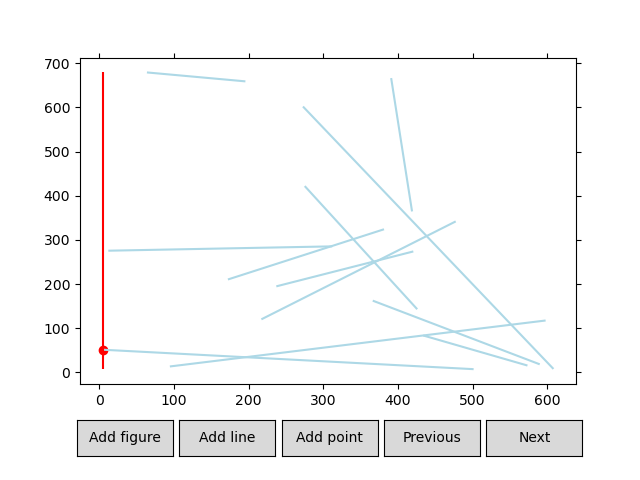

In [29]:
c = draw_line_segments((0, 700), (5, 700), 12)
res, scenes = does_any_pair_intersects(c)
print(res)
plot = Plot(scenes)
plot.draw()

### Function for computing the number of all intersections of line segments

In [25]:
def check_for_intersection(ls1, ls2, p, Q, result, segments):
    point = get_intersection_point(ls1, ls2)
    if point and point.x > p.x and (point.x, point.y) not in result:
        Q.add(point)
        result.add((point.x, point.y))
        segments.append((((ls1.start.x, ls1.start.y), (ls1.end.x, ls1.end.y)), ((ls2.start.x, ls2.start.y), (ls2.end.x, ls2.end.y))))
        

    
def get_all_pairs_intersections(raw_lines):
    T = sc.SortedSet()
    Q = sc.SortedSet()
    
    lines, points, limit_max, limit_min = prepare_data(raw_lines)
    for point in points:
        Q.add(point)
    
    result = set()
    segments = []
    scenes = []
    while len(Q) > 0:
        p = Q.pop()
        
        scenes.append(Scene([PointsCollection(list(result), color = "green"), PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))

        
        if p == lines[p.s].start:
            Line.set_ordering(p.x)
            T.add(lines[p.s])
            
            T_idx = T.index(lines[p.s])
            if T_idx - 1 >= 0:
                check_for_intersection(T[T_idx], T[T_idx - 1], p, Q, result, segments)
            if T_idx + 1 < len(T):
                check_for_intersection(T[T_idx], T[T_idx + 1], p, Q, result, segments)
            
            scenes.append(Scene([PointsCollection(list(result), color = "green"), PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
        
        elif p == lines[p.s].end:
            
            T_idx = T.index(lines[p.s])
            if T_idx + 1 < len(T) and T_idx - 1 >= 0:
                check_for_intersection(T[T_idx - 1], T[T_idx + 1], p, Q, result, segments)
                
            T.remove(lines[p.s])
            
            scenes.append(Scene([PointsCollection(list(result), color = "green"), PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
        
        else:
            line1 = lines[p.s]
            line2 = lines[p.t]
            
            T.remove(line1)
            T.remove(line2)
            
            Line.set_ordering(p.x + 0.00000000001)
            
            T.add(line1)
            T.add(line2)
            
            T_idx1 = T.index(line1)
            T_idx2 = T.index(line2)
            
            if T_idx1 > T_idx2:
                T_idx1, T_idx2 = T_idx2, T_idx1
            
            if T_idx1 - 1 >= 0:
                check_for_intersection(T[T_idx1], T[T_idx1 - 1], p, Q, result, segments)
            if T_idx2 + 1 < len(T):
                check_for_intersection(T[T_idx2], T[T_idx2 + 1], p, Q, result, segments)
            
            scenes.append(Scene([PointsCollection(list(result), color = "green"), PointsCollection([(p.x, p.y)], color='red')],
                            [LinesCollection(raw_lines, color='lightblue'), LinesCollection([[(p.x, limit_min), (p.x, limit_max)]], color='red'),
                             LinesCollection([[(l.start.x, l.start.y), (l.end.x, l.end.y)] for l in T], color='yellow')]))
            
            
    return result, segments, scenes

Number of intersections:  14


<IPython.core.display.Javascript object>


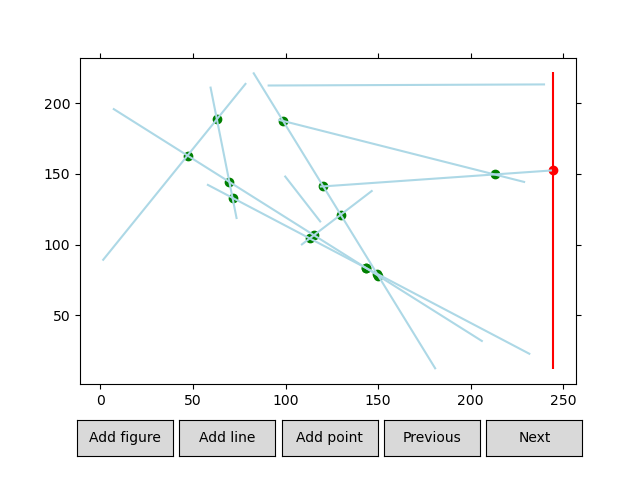

In [30]:
d = draw_line_segments((0, 250), (5, 250), 10)
res, segments, scenes = get_all_pairs_intersections(d)

print("Number of intersections: ", len(res))
#print(segments)
plot = Plot(scenes)
plot.draw()

### The plot for adding interactively line segments

<IPython.core.display.Javascript object>


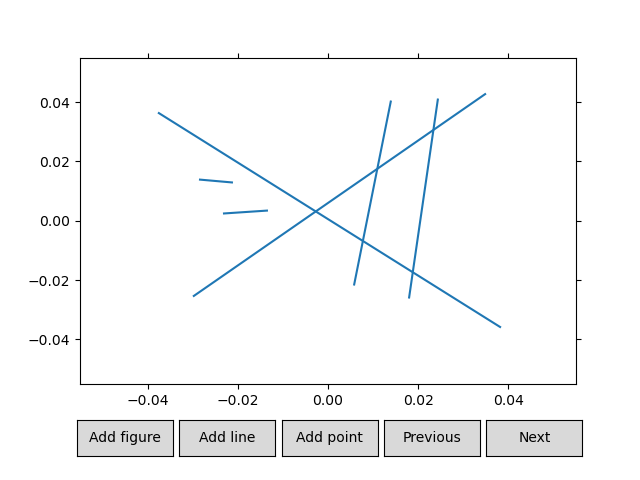

In [17]:
plot = Plot()
plot.draw()

Number of intersections:  5


<IPython.core.display.Javascript object>


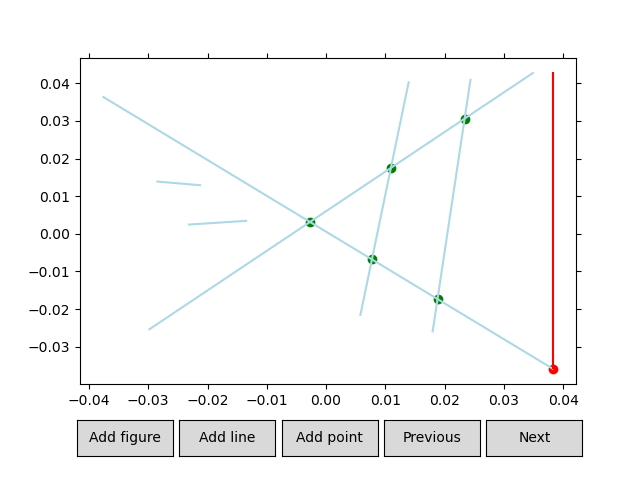

In [18]:
res, segments, scenes = get_all_pairs_intersections(get_added_lines(plot))

print("Number of intersections: ", len(res))
#print(segments)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


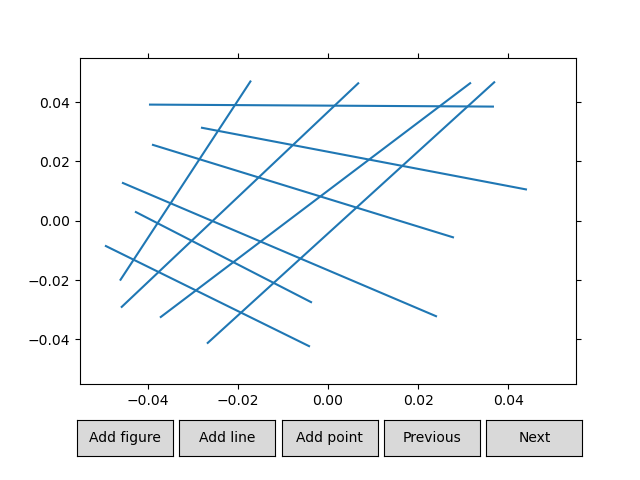

In [19]:
plot = Plot()
plot.draw()

Number of intersections:  24


<IPython.core.display.Javascript object>


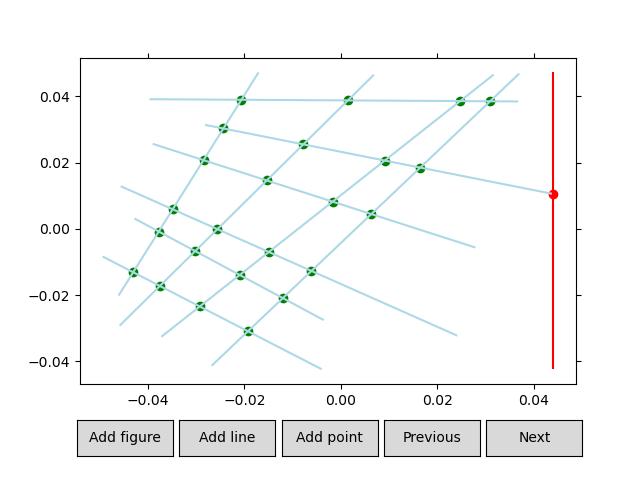

In [20]:
res, segments, scenes = get_all_pairs_intersections(get_added_lines(plot))

print("Number of intersections: ", len(res))
#print(segments)
plot = Plot(scenes)
plot.draw()

<IPython.core.display.Javascript object>


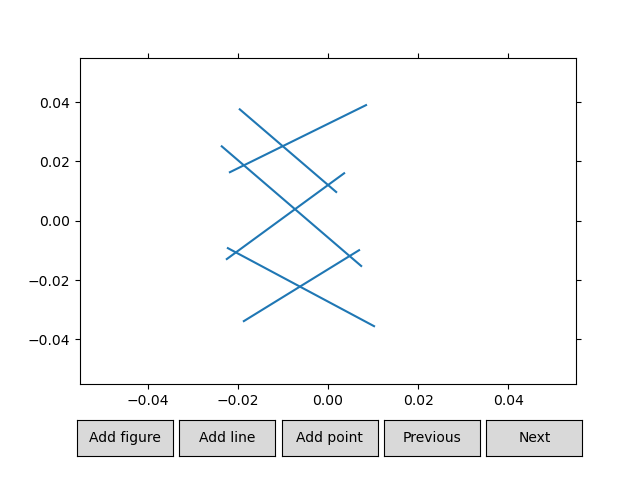

In [27]:
plot = Plot()
plot.draw()

Number of intersections:  8


<IPython.core.display.Javascript object>


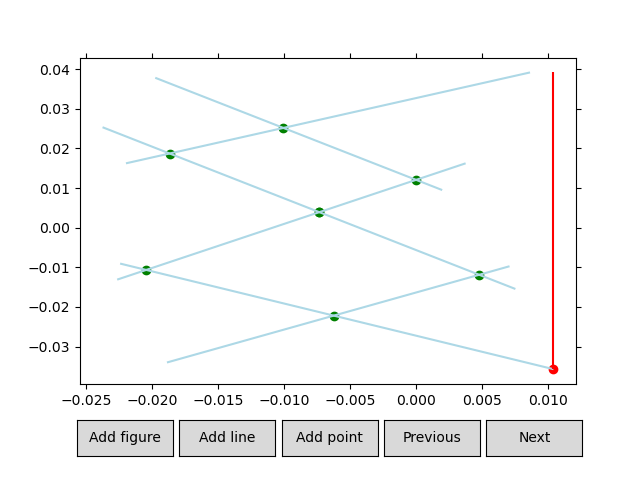

In [28]:
res, segments, scenes = get_all_pairs_intersections(get_added_lines(plot))

print("Number of intersections: ", len(res))
#print(segments)
plot = Plot(scenes)
plot.draw()